# ECON323 Final Project

### Which area in Metro Vancouver and what kind of real estate is best to invest in?

In the project, the recent price to rent ratio of different areas in Metro Vancouver will be compared. Also, the house price of three types house in different areas for the peirod 2005 to 2021 will be compared. Then, I will investigate how immigration, mortgage rates, inflation and unemplyment rate influnce house price in Metro Vancouver.

In [35]:
import matplotlib.colors as mplc
import matplotlib.patches as patches
import qeds
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import geopandas as gpd
from geopandas import GeoDataFrame
import geojson
from bokeh.io import output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.palettes import brewer
import bokeh.palettes as palettes
import json
import statsmodels.api as sm
output_notebook()

Loading BokehJS ...

### Improting the data

In [36]:
boundary = "https://raw.githubusercontent.com/nford/metro-vancouver-boundaries/master/metro-vancouver-boundaries.geojson"
van_geojson = gpd.read_file(boundary)
url_rent = "https://raw.githubusercontent.com/pennypan18/323final/main/Price-to-rent%20ratio%202020%3A10.csv"
rent = pd.read_csv(url_rent)
url2 = "https://raw.githubusercontent.com/pennypan18/323final/main/house%20price%202005-2021.csv"
house_price0 = pd.read_csv(url2)
url_hpi = "https://raw.githubusercontent.com/pennypan18/323final/main/HPI%202021%3A03.csv"
hpi0 = pd.read_csv(url_hpi)
url_mor = "https://raw.githubusercontent.com/pennypan18/323final/main/Mortgage%20rate(5-year%20term).csv"
mort_rate = pd.read_csv(url_mor)
url_inf = "https://raw.githubusercontent.com/pennypan18/323final/main/inflation.csv"
inf_rate = pd.read_csv(url_inf)
url_imm = "https://raw.githubusercontent.com/pennypan18/323final/main/immgration.csv"
imm = pd.read_csv(url_imm)
url_unem = "https://raw.githubusercontent.com/pennypan18/323final/main/bcunemployment%20rate.csv"
unem_rate = pd.read_csv(url_unem)

### Cleaning the data

In [37]:
#Merging the price-to-rent ratio into geometry 
v = van_geojson.rename(columns={"ShortName" : "Area"})[["Area","geometry"]]
rent_map = v.merge(rent, how = "left", on = "Area")

In [38]:
#From monthly to annual house price from 2005 to 2021
house_price0["year"]=pd.DatetimeIndex(house_price0["Period"]).year
x = house_price0.groupby(["House_type","Area","year"]).mean()
house_price = x.reset_index()

In [39]:
#Reshaping HPI with area as index and house type as column
hpi = (hpi0.pivot_table(index="Area", columns="House_type", values="HPI"))

In [40]:
#From monthly to annual data
mort_rate["year"]=pd.DatetimeIndex(mort_rate["Date"]).year
annual1 = mort_rate.groupby(["year"]).mean()
mort_rate_annual = annual1.reset_index()

inf_rate["year"]=pd.DatetimeIndex(inf_rate["Date"]).year
annual2 = inf_rate.groupby(["year"]).mean()
inf_rate_annual = annual2.reset_index()

imm["year"]=pd.DatetimeIndex(imm["Date"]).year
annual3 = imm.groupby(["year"]).sum()
imm_annual = annual3.reset_index()

In [41]:
#Merging unemployment rate, immigration, inflation and mortgage rate into house price table
from functools import reduce
data_frames = [house_price, unem_rate, imm_annual,inf_rate_annual,mort_rate_annual]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['year'], how='left'), data_frames)

#Removing missing values
linear = df_merged.dropna()

### Price-to-Ratio Map

The price-to-rent ratio is used as a benchmark for estimating whether it's cheaper to rent or own property. The formula of it is $$\frac{\text{Real Estate Price}}{\text{Annual rent}}$$.

High ratio implies that renting is a better financial choice.

In [42]:
#Convert data to geojson for bokeh
rent_geojson=GeoJSONDataSource(geojson=rent_map.to_json())

color_mapper = LinearColorMapper(palette = brewer['OrRd'][8][::-1], low = 0, high = 160)
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')
hover = HoverTool(tooltips = [ ('Area','@Area'),('Average Rental Price', '@Average_Rental_Price'),
                               ('Average Price','@Average_Price'),
                               ('Rental ratio','@Rental_ratio')])
p = figure(title="Price-to-Rent Ratio in October 2020", tools=[hover])
p.patches("xs","ys",source=rent_geojson,
          fill_color = {'field' :'Rental_ratio', 'transform' : color_mapper})
p.add_layout(color_bar, 'below')
show(p)

### House Price between 2005 to 2021

Showing the trend of house price in different area, and the highest and the second highest house prices are demonstrated.

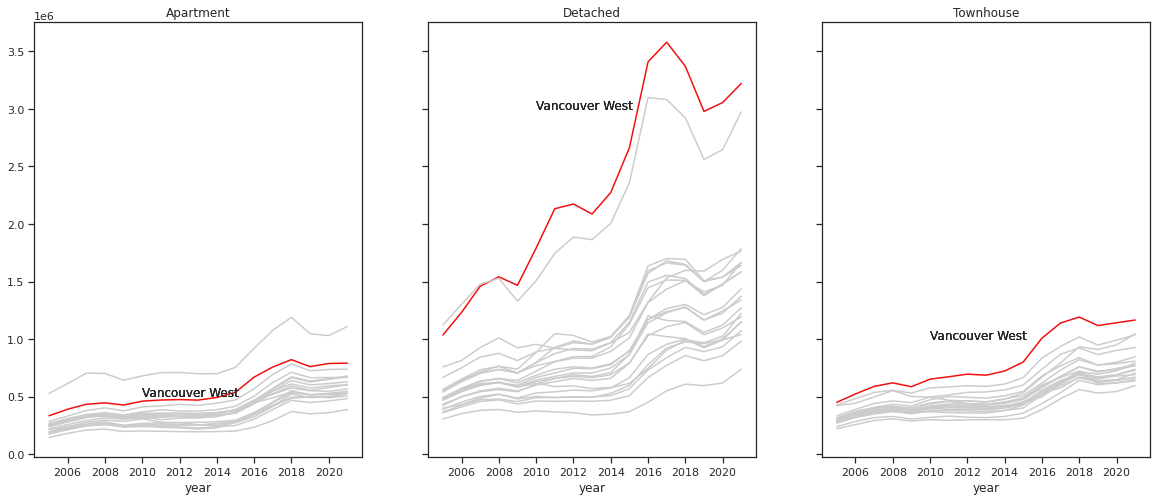

In [9]:
def single_scatter_plot(df, area, housetype, ax, color):

    # Filter data to keep only the data of interest
    _df = df.query("(Area == @area) & (House_type == @housetype)")
    _df.plot(
         x="year", y="Benchmark", ax=ax, color=color,legend=False)

    return ax

fig, ax = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

for (i, House_type) in enumerate(house_price.House_type.unique()):
    single_scatter_plot(house_price, "Lower Mainland", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Bowen Island", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Burnaby East", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Burnaby North", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Burnaby South", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Coquitlam", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Ladner", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Maple Ridge", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "New Westminster", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "North Vancouver", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Pitt Meadows", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Port Coquitlam", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Port Moody", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Richmond", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Squamish", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Sunshine Coast", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Tsawwassen", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Vancouver East", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Vancouver West", House_type, ax[i],(0.95, 0.05, 0.05))
    single_scatter_plot(house_price, "West Vancouver", House_type, ax[i],(0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Whistler", House_type, ax[i], (0.8, 0.8, 0.8))
    ax[i].set_title(str(House_type))
    ax[0].text(2010,500000,"Vancouver West")
    ax[1].text(2010,3000000,"Vancouver West")
    ax[2].text(2010,1000000,"Vancouver West")

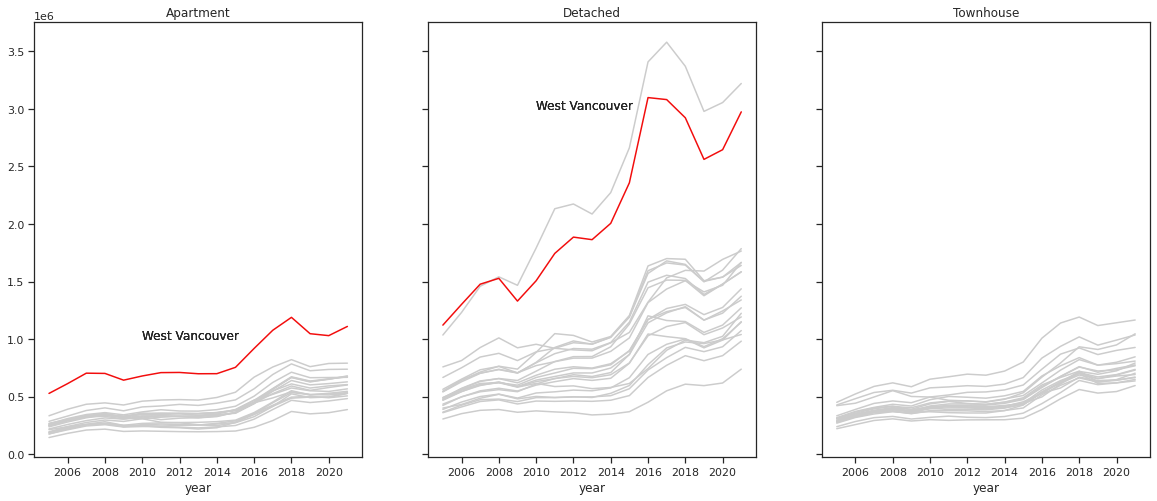

In [10]:
def single_scatter_plot(df, area, housetype, ax, color):

    # Filter data to keep only the data of interest
    _df = df.query("(Area == @area) & (House_type == @housetype)")
    _df.plot(
         x="year", y="Benchmark", ax=ax, color=color,legend=False)

    return ax

fig, ax = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

for (i, House_type) in enumerate(house_price.House_type.unique()):
    single_scatter_plot(house_price, "Lower Mainland", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Bowen Island", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Burnaby East", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Burnaby North", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Burnaby South", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Coquitlam", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Ladner", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Maple Ridge", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "New Westminster", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "North Vancouver", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Pitt Meadows", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Port Coquitlam", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Port Moody", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Richmond", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Squamish", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Sunshine Coast", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Tsawwassen", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Vancouver East", House_type, ax[i], (0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "Vancouver West", House_type, ax[i],(0.8, 0.8, 0.8))
    single_scatter_plot(house_price, "West Vancouver", House_type, ax[i], (0.95, 0.05, 0.05))
    single_scatter_plot(house_price, "Whistler", House_type, ax[i], (0.8, 0.8, 0.8))
    ax[i].set_title(str(House_type))
    ax[0].text(2010,1000000,"West Vancouver")
    ax[1].text(2010,3000000,"West Vancouver")

### House Price Index (HPI)

The house price index measures the price changes as a percentage change from January, 2005 with HPI of 100. The data below is the HPI in March, 2021.

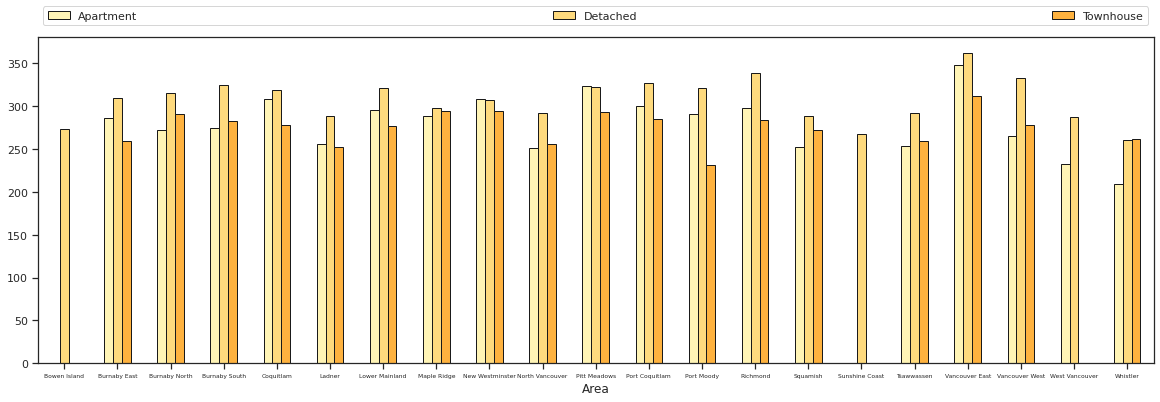

In [11]:
def create_barplot(df, colors):

    fig, ax = plt.subplots(figsize=(20, 6))

    df.plot(kind="bar", color=colors, ax=ax, edgecolor="k", rot=0)
    ax.legend(bbox_to_anchor=(0, 1.02, 1.0, 1.02), loc=3, mode="expand", ncol=5)
    ax.set_xticklabels(df.index, fontsize=6)

    return fig

colors = sns.color_palette("YlOrBr")

create_barplot(hpi, colors);

### Linear Regression

In [34]:
fit = ols('np.log(Benchmark) ~ C(House_type)*C(Area)+year+Unemployment_rate+Total_immigration+inflation+mortgage_rate', data=linear).fit() 
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(Benchmark)   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     402.5
Date:                Thu, 29 Apr 2021   Prob (F-statistic):               0.00
Time:                        19:13:51   Log-Likelihood:                 823.45
No. Observations:                 870   AIC:                            -1521.
Df Residuals:                     807   BIC:                            -1220.
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                              -154.0310      9.244    -16.663      0.000    -172.176    -135.886
C(House_type)[T.Detached]                                -3.2365      0.237    -13.631      0.000      -3.703      -2.770
C(House_type)[T.Townhouse]                                0.2878      0.008     36.199      0.000       0.272       0.303
C(Area)[T.Burnaby East]                                  -3.5799      0.239    -15.001      0.000      -4.048      -3.111
C(Area)[T.Burnaby North]                                 -3.7920      0.239    -15.890      0.000      -4.260      -3.324
C(Area)[T.Burnaby South]                                 -3.6863      0.239    -15.447      0.000      -4.155      -3.218
C(Area)[T.Coquitlam]                                     -4.0166      0.239    -16.831      0.000      -4.485      -3.548
C(Area)[T.Ladner]                                        -3.8615      0.239    -16.181      0.000      -4.330      -3.393
C(Area)[T.Lower Mainland]                                -3.7410      0.239    -15.677      0.000      -4.209      -3.273
C(Area)[T.Maple Ridge]                                   -4.3175      0.239    -18.092      0.000      -4.786      -3.849
C(Area)[T.New Westminster]                               -3.9881      0.239    -16.712      0.000      -4.457      -3.520
C(Area)[T.North Vancouver]                               -3.7828      0.239    -15.852      0.000      -4.251      -3.314
C(Area)[T.Pitt Meadows]                                  -4.0542      0.239    -16.989      0.000      -4.523      -3.586
C(Area)[T.Port Coquitlam]                                -4.1161      0.239    -17.248      0.000      -4.585      -3.648
C(Area)[T.Port Moody]                                    -3.7982      0.239    -15.916      0.000      -4.267      -3.330
C(Area)[T.Richmond]                                      -3.7504      0.239    -15.716      0.000      -4.219      -3.282
C(Area)[T.Squamish]                                      -4.0617      0.239    -17.020      0.000      -4.530      -3.593
C(Area)[T.Sunshine Coast]                                -0.2447      0.018    -13.747      0.000      -0.280      -0.210
C(Area)[T.Tsawwassen]                                    -3.7934      0.239    -15.896      0.000      -4.262      -3.325
C(Area)[T.Vancouver East]                                -3.8472      0.239    -16.121      0.000      -4.316      -3.379
C(Area)[T.Vancouver West]                                -3.4729      0.239    -14.553      0.000      -3.941      -3.004
C(Area)[T.West Vancouver]                                -3.0926      0.239    -12.960      0.000      -3.561      -2.624
C(Area)[T.Whistler]              

The predict function will be $$y=-154.031-3.2365d_1+0.2878d_2-3.5799z_1-3.7920z_2+...-3.9524z_{20}+3.7683d_1z_1-0.3437d_2z_1+...+4.4272d_1z_{20}+0.2674d_2z_{20}+0.0846x_1-0.0068x_2-1.646\times10^{-6}x_3-0.0238x_4+0.1431x_5+\mathcal{E}$$

where $d_1=
\begin{cases}
1, if\ it\ is\ detached \\
0, other\ types
\end{cases}$
$d_2=
\begin{cases}
1, if\ it\ is\ townhouse \\
0, other\ types
\end{cases}$

$z_1=
\begin{cases}
1, \text{if it is in Burnaby East} \\
0, \text{other types}
\end{cases}$
$z_2=
\begin{cases}
1, \text{if it is in Burnaby North} \\
0, \text{other types}
\end{cases}$
...
$z_{20}=
\begin{cases}
1, \text{if it is in Whistler} \\
0, \text{other types}
\end{cases}$

$x_1$=year, $x_2$=unemployment rate, $x_3$=immigration, $x_4$=inflation, and $x_5$=mortgage rate.

<ipython-input-26-1bcb4e6b461d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linear["log_Ben"] = np.log(linear["Benchmark"])


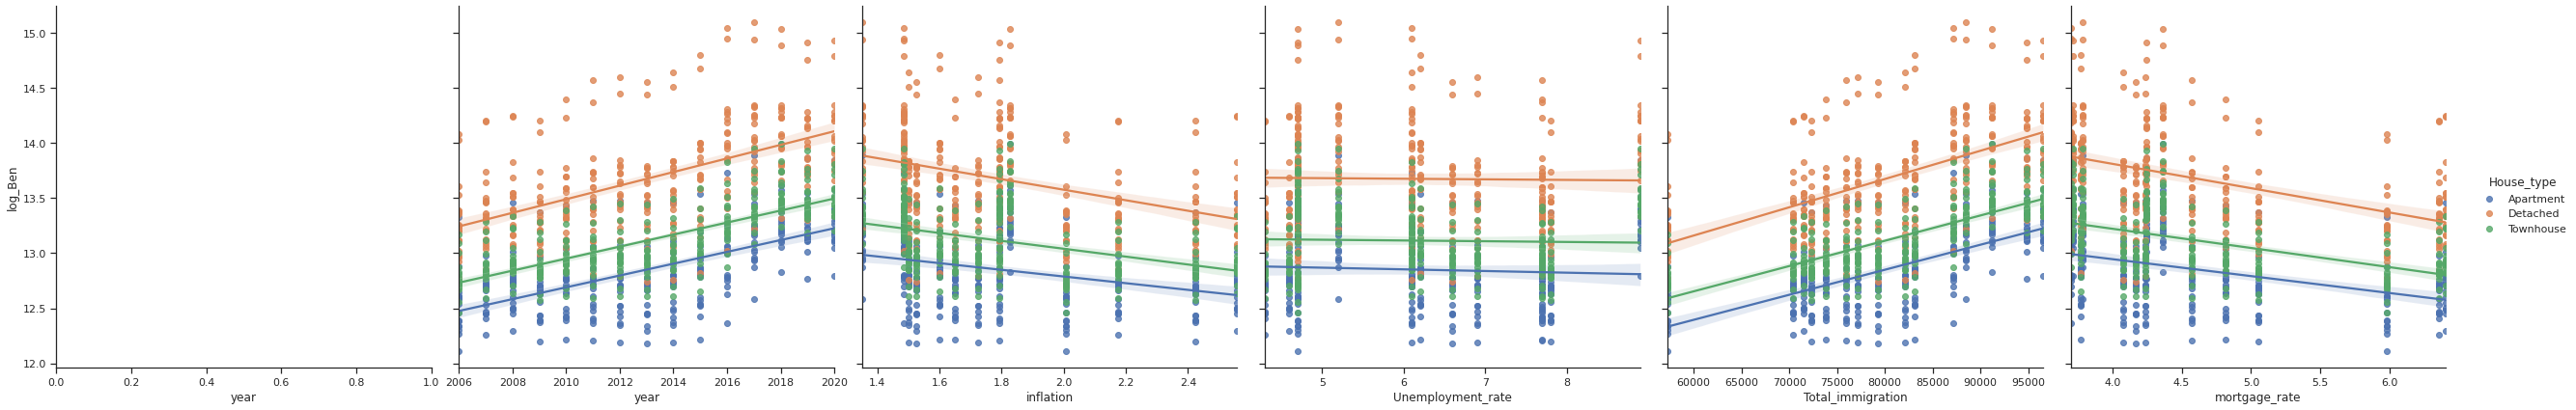

In [26]:
linear["log_Ben"] = np.log(linear["Benchmark"])
sns.pairplot(data=linear, x_vars=["year","year","inflation", "Unemployment_rate","Total_immigration","mortgage_rate"], 
             y_vars=["log_Ben"],
             hue="House_type", height=6, aspect=1, kind="reg");

### Conclusion

West Vancouver has the highest price-to-rent ratio, the highest average price of appartements, and the second highest price of detached, where is not a right place to invest. 

From the HPI plot, detached is the highest, comparing with other types in all area except New Westminster. The first three highest HPI of detached in Vancouver East, Vancouver West, and Richmond respectively. Then, comparing the price-to-rent ratio in Vancouver and Richmond, Vancouver has lower ratio with 53.382. Therefore, detached in Vancouver East is the best to investment, which with lower price-to-rent ratio and highest HPI.

According the linear regression summary, year and mortgage rate are statistically significant due to the relative small p-values. From the linear plot, year, immigration are positive correlation with house price, however, inflation and mortgage rate are negative correlation with house price. Unemployment rate is almost no correlation with house price.

### Limitation

1.	Linear Regression 

There are strong data-based multicollinearity, which implies that some predictors variables are highly correlated (not independent)$^9$. The house price data changes over time,however, the house price would increase in long run, leading to the multicollinearity.

2.	Classification in Linear Regression

When the house in Metro Vancouver is appreciating in general, price would increase for every type and every area.

### Reference
1. Metro Vancouver boundaries https://github.com/nford/metro-vancouver-boundaries
2. Rental Market Statistics Summery by Census Subdivision, October, 2020 https://www03.cmhc-schl.gc.ca/hmip-pimh/en/TableMapChart/Table?TableId=2.1.31.3&GeographyId=2410&GeographyTypeId=3&DisplayAs=Table&GeograghyName=Vancouver
3. House Price of three type in different areas, 2005-2021 https://www.rebgv.org/market-watch/MLS-HPI-home-price-comparison.html
4. House Price of Metro Vancouver, 2005-2021 https://www.crea.ca/housing-market-stats/mls-home-price-index/
5. Mortgage Rate of Canada, 2005-2021 https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=3410014501
6. Inflation Rate of Canada, 2006-2021 https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810025602 
7. Total Immigration of Canada, 2006-2021 https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=1410008401
8. Unemployment Rate of British Columbia, 2005-2020 https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=1410032701
9. Daoud, J. I. (2017, December). Multicollinearity and regression analysis. In Journal of Physics: Conference Series (Vol. 949, No. 1, p. 012009). IOP 